In [ ]:
import sys

sys.path.append("../")

A place to test random stuff

In [ ]:
import torch
import torch.nn as nn
from monkey.model.utils import (
    get_classification_metrics,
    get_activation_function,
)
from monkey.model.loss_functions import get_loss_function, dice_coeff
import numpy as np
from pprint import pprint

In [ ]:
true_mask = torch.zeros(size=(1, 1, 256, 256))
true_mask[0, 0, 0, 0] = 0.5
print(true_mask)
pred_mask = torch.zeros(size=(1, 1, 256, 256))
print(pred_mask)
true_mask[0, 0, 0, 0] = 0.5
loss_fn = get_loss_function("Jaccard_Loss")
loss = loss_fn.compute_loss(pred_mask, true_mask)
pprint(loss)

In [ ]:
test = torch.zeros(size=(16, 3, 256, 256))
# test[0,0,0,0] = 1

no_pos = torch.count_nonzero(test).item()
no_negs = torch.numel(test) - no_pos
print(no_negs, no_pos)
# weight = no_negs / no_pos
# print(weight)
eps = 1e-6
weight_0 = torch.numel(test) / (2 * no_negs + eps)
weight_1 = torch.numel(test) / (2 * no_pos + eps)

print(weight_0)
print(weight_1)

CONCH

In [ ]:
from conch.open_clip_custom import (
    create_model_from_pretrained,
    tokenize,
    get_tokenizer,
)
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
model_cfg = "conch_ViT-B-16"
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
checkpoint_path = "/home/u1910100/Downloads/pytorch_model.bin"
model, preprocess = create_model_from_pretrained(
    model_cfg, checkpoint_path, device=device
)
_ = model.eval()

tokenizer = get_tokenizer()
classes = ["lymphocyte", "monocyte"]
prompts = [
    "a PAS stained image of a lymphocyte",
    "a PAS stained image of a monocyte",
]

tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(
    device
)
tokenized_prompts.shape

In [ ]:
from monkey.data.dataset import get_classification_dataloaders
from monkey.config import TrainingIOConfig

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 32
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
pred_probs_list = []
true_labels_list = []

for data in tqdm(val_loader):
    file_ids = data["id"]

    images, true_labels = (
        data["image"].cuda().float(),
        data["label"].cpu().tolist(),
    )

    true_labels_list.extend(true_labels)
    pred_probs = []

    with torch.inference_mode():
        image_embedings = model.encode_image(images)
        text_embedings = model.encode_text(tokenized_prompts)
        sim_scores = (
            (
                image_embedings
                @ text_embedings.T
                * model.logit_scale.exp()
            )
            .softmax(dim=-1)
            .cpu()
            .numpy()
        )

        pred_probs_list.extend(sim_scores[:, 1])

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from monkey.model.utils import get_classification_metrics

pred_probs_list = np.array(pred_probs_list)
true_labels_list = np.array(true_labels_list)
fpr, tpr, thresholds = metrics.roc_curve(
    true_labels_list, pred_probs_list
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name="cell classifier",
)
display.plot()
plt.show()

thresh = 0.5
pred_labels_list = np.where(pred_probs_list > thresh, 1, 0)
scores = get_classification_metrics(
    true_labels_list, pred_labels_list
)
print(scores)
metrics.ConfusionMatrixDisplay.from_predictions(
    true_labels_list,
    pred_labels_list,
    display_labels=["lymphocyte", "monocyte"],
)
plt.show()

In [ ]:
data = next(iter(val_loader))
images = data["image"].to("cuda").float()
print(data["label"])

with torch.inference_mode():
    image_embedings = model.encode_image(images)
    text_embedings = model.encode_text(tokenized_prompts)
    sim_scores = (
        (image_embedings @ text_embedings.T * model.logit_scale.exp())
        .softmax(dim=-1)
        .cpu()
        .numpy()
    )

pred_class = sim_scores.argmax()
print(pred_class)
print(sim_scores)
print(sim_scores[:, 1])
# print("Predicted class:", classes[sim_scores.argmax()])
# print(
#     "Normalized similarity scores:",
#     [
#         f"{cls}: {score:.3f}"
#         for cls, score in zip(classes, sim_scores[0])
#     ],
# )

CellViT

In [ ]:
import sys

sys.path.append("../")
import torch
from monkey.model.cellvit.cellvit import CellViT256, CellVit256_Unet

model_path = "/home/u1910100/Downloads/HIPT_vit256_small_dino.pth"
device = "cuda"

model = CellVit256_Unet(num_decoders=3)

model.load_pretrained_encoder(model_path)

model.eval()
print(model)

test = torch.rand(size=(4, 3, 256, 256))
out = model(test)
print(out.shape)

MapDe Filter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from scipy import ndimage, signal

sys.path.append("../")
from monkey.data.data_utils import erode_mask, generate_regression_map
import cv2
from skimage import draw

cell_mask = np.zeros(shape=(256, 256), dtype=np.uint8)
rr, cc = draw.ellipse(100, 100, 1, 1, shape=cell_mask.shape)
# rr, cc = 100, 100
cell_mask[rr, cc] = 1
plt.imshow(cell_mask)
plt.show()


def gauss_2d_filter(shape=(11, 11)):
    sigma = int((shape[0] - 1) / 6)
    m, n = [(ss - 1.0) / 2.0 for ss in shape]
    y, x = np.ogrid[-m : m + 1, -n : n + 1]
    h = np.exp(-(x * x + y * y) / (2.0 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh

    h = h / (h[int(m), int(n)])
    return h


dist_filter = gauss_2d_filter(shape=(17, 17))
plt.imshow(dist_filter)
plt.show()
# cell_mask = generate_regression_map(cell_mask, d_thresh=5, alpha=0.5, scale=1)
# plt.imshow(cell_mask)
# plt.show()

cell_mask = signal.convolve2d(cell_mask, dist_filter)
print(np.max(cell_mask))
plt.imshow(cell_mask)
plt.show()

Multihead Unet

In [ ]:
import sys

sys.path.append("../")
from pprint import pprint
import torch

torch.manual_seed(0)
from torchvision.models.efficientnet import (
    efficientnet_b0,
)
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from torchinfo import summary


model = get_multihead_efficientunet(
    out_channels=[2, 1], pretrained=True
)
model.eval()
model.to("cuda")
summary(model, input_size=(1, 3, 256, 256))

In [ ]:
with torch.no_grad():
    test_input = torch.ones(
        size=(1, 3, 256, 256), dtype=torch.float, device="cuda"
    )
    model_out = model(test_input)
    pprint(model_out)

MapDe model

In [ ]:
import sys
import torch

sys.path.append("../")

from monkey.model.mapde.model import MapDe
from monkey.data.dataset import get_detection_dataloaders
from monkey.config import TrainingIOConfig
import matplotlib.pyplot as plt
import numpy as np
from monkey.data.data_utils import imagenet_denormalise
import torch

use_nuclick_masks = False
batch_size = 1
module = "detection"

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=5,
    dataset_name="detection",
    batch_size=batch_size,
    disk_radius=1,
    regression_map=False,
    do_augmentation=True,
    module=module,
    use_nuclick_masks=use_nuclick_masks,
    include_background_channel=False,
)


model = MapDe(3, 30, 50, num_classes=1, filter_size=31)
model.eval()
# print(model)
test_input = torch.ones(size=(4, 3, 252, 252), dtype=torch.float)

with torch.no_grad():
    out = model(test_input)
print(f"output size = {out.size()}")
# print(torch.max(out))

In [ ]:
data = next(iter(train_loader))

fig, axes = plt.subplots(1, 3, figsize=(18, 18))

image = data["image"][0].numpy()
image = np.moveaxis(image, 0, 2)
image = imagenet_denormalise(image)
axes[0].imshow(image)

mask = data["mask"]
mask_filtered = model.blur_cell_points(mask)


axes[1].imshow(image, alpha=0.5)
mask_filtered_numpy = mask_filtered.numpy()
axes[1].imshow(mask_filtered_numpy[0][0], alpha=0.5)
axes[2].imshow(mask_filtered_numpy[0][0])
plt.show()

In [ ]:
test_logits = torch.rand(size=(2, 3, 252, 252))

model.eval()
with torch.no_grad():
    logits = model(test_logits)
    probs = model.logits_to_probs(logits)
print(logits)

out_masks = model.postproc(logits)
out_masks = out_masks[:, np.newaxis, :, :]
out_masks = model.blur_cell_points(out_masks)

logits = logits.numpy(force=True)
probs = probs.numpy(force=True)


plt.imshow(logits[0][0])
plt.show()
print(np.max(logits[0][0]))

plt.imshow(probs[0][0])
plt.show()

# print(np.max(logits))
plt.imshow(out_masks[0][0])
plt.show()

import skimage

inflamm_labels = skimage.measure.label(out_masks[0][0])
inflamm_stats = skimage.measure.regionprops(
    inflamm_labels, intensity_image=probs[0][0]
)
for region in inflamm_stats:
    centroid = region["centroid"]

    c, r, confidence = (
        centroid[1],
        centroid[0],
        region["mean_intensity"],
    )
    print(c, r, confidence)

HoverNext

In [ ]:
import sys
import torch
from torchinfo import summary

sys.path.append("../")
import numpy as np
from monkey.model.hovernext.model import (
    get_custom_hovernext,
    get_convnext_unet,
    get_timm_encoder,
    load_encoder_weights,
)

model = get_custom_hovernext(
    pretrained=False,
    num_heads=2,
    decoders_out_channels=[1, 1],
    use_batchnorm=True,
    attention_type="scse",
)
# model = get_convnext_unet(
#     out_classes=2, use_batchnorm=True, attention_type="scse"
# )
checkpoint_path = "/home/u1910100/Downloads/lizard_convnextv2_large/train/best_model"
model = load_encoder_weights(model, checkpoint_path)
model.eval()

In [ ]:
import torch

test_input = torch.ones(size=(1, 3, 256, 256))

with torch.no_grad():
    out = model(test_input)

print(out.shape)

Pannuke Masks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from monkey.data.data_utils import (
    generate_regression_map,
    dilate_mask,
    load_image,
    load_mask,
)
from monkey.data.dataset import class_mask_to_multichannel_mask

cell_mask = np.zeros(shape=(256, 256), dtype=np.uint8)
cell_mask[100, 100] = 1

cell_mask = dilate_mask(cell_mask, 3)

plt.imshow(cell_mask)
plt.show()

cell_mask = generate_regression_map(
    cell_mask, d_thresh=7, alpha=3, scale=1
)
plt.imshow(cell_mask)
plt.show()

In [ ]:
mask_path = "/home/u1910100/Documents/Monkey/patches_256/annotations/masks/C_P000029_18592_66528_18848_66784.npy"
mask = np.load(mask_path)
class_mask = class_mask_to_multichannel_mask(mask)

plt.imshow(class_mask[0])
plt.show()
plt.imshow(class_mask[1])
plt.show()

import scipy.ndimage as ndi

dist = ndi.distance_transform_edt(class_mask[0] == 0)
M = (np.exp(3 * (1 - dist / 7)) - 1) / (np.exp(3) - 1)
M[M < 0] = 0
M *= 1

plt.imshow(M)
plt.show()

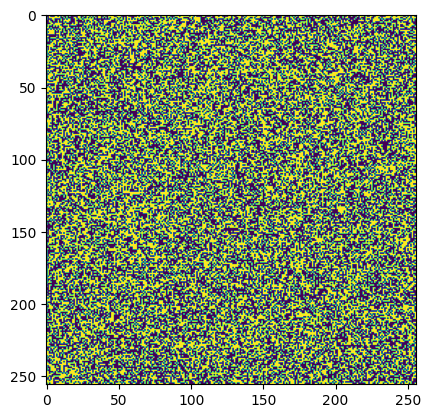

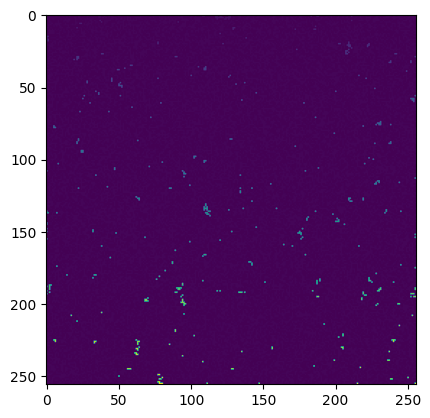

(0.0, 0.0)
(2.0555555555555554, 6.111111111111111)
(127.30080520284918, 127.17890987921957)
(0.3333333333333333, 16.333333333333332)
(1.0, 38.18181818181818)
(0.0, 54.0)
(0.0, 87.0)
(0.0, 105.0)
(0.5, 108.0)
(0.0, 112.0)
(1.3571428571428572, 122.0)
(0.3333333333333333, 184.0)
(0.6666666666666666, 187.66666666666666)
(0.5, 211.0)
(2.5, 0.0)
(4.5, 37.5)
(4.0, 211.0)
(5.0, 91.0)
(6.0, 23.5)
(8.0, 186.0)
(9.0, 21.0)
(9.333333333333334, 129.33333333333334)
(10.0, 172.0)
(10.0, 185.5)
(13.0, 120.0)
(16.2, 0.6)
(16.0, 138.0)
(19.5, 77.0)
(21.125, 209.375)
(20.0, 122.0)
(20.0, 202.5)
(21.0, 222.5)
(24.0, 173.0)
(25.714285714285715, 207.85714285714286)
(27.0, 38.5)
(27.0, 241.5)
(29.8, 21.4)
(29.0, 89.5)
(29.0, 255.0)
(31.0, 19.0)
(32.666666666666664, 237.66666666666666)
(32.5, 252.0)
(35.0, 58.5)
(36.0, 105.0)
(37.2, 109.6)
(37.0, 54.0)
(38.0, 49.5)
(39.0, 249.0)
(42.0, 100.0)
(42.5, 126.5)
(42.0, 216.0)
(45.0, 45.0)
(44.0, 77.0)
(44.0, 221.0)
(46.5, 28.0)
(48.666666666666664, 51.0)
(47.0, 137

In [1]:
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import numpy as np

example_mask = np.random.randint(0, 2, size=(256, 256))


plt.imshow(example_mask)
plt.show()

labels = label(example_mask)
plt.imshow(labels)
plt.show()

props = regionprops(labels)
for prop in props:
    print(prop.centroid)